In [52]:
import numpy as np

from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from src import sinkhorn, multigrid

Testing the performance on the image transfer from two pictures: 
- Daylight picture of the sea
- Sunset picture

Load images and show them

In [2]:
I1 = plt.imread('images/ocean_daylight.png').astype(np.float64)[:, :, :3]
I2 = plt.imread('images/ocean_sunset.png').astype(np.float64)[:, :, :3]

(-0.5, 353.5, 263.5, -0.5)

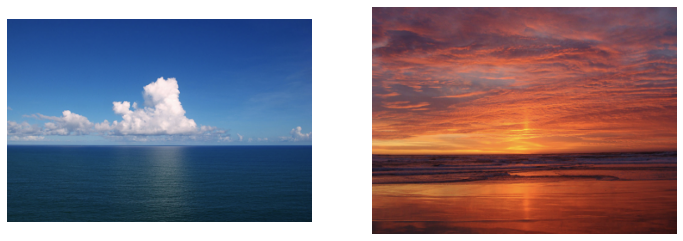

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(I1)
ax[1].imshow(I2)

ax[0].axis('off')
ax[1].axis('off')

Sample some fixed number of points, which would represent the distribtuon of pixels, and then solve the optimal transport problem.

In [3]:
n_samples = 1024

x_i = I1.reshape(-1, 3)[np.random.randint(0, I1.shape[0] * I1.shape[1], n_samples)]
x_f = I2.reshape(-1, 3)[np.random.randint(0, I2.shape[0] * I2.shape[1], n_samples)]

C = cdist(x_i, x_f)

a = np.ones(n_samples) / n_samples
b = np.ones(n_samples) / n_samples

Here we are plotting the sampled points, and how can the assigment look like.

In [20]:
G = sinkhorn.sinkhorn_knopp(C, reg = 1e-3, a = a, b = b)

(-0.016470586322247988,
 1.0360784320160747,
 0.03901961036026477,
 0.992352944239974)

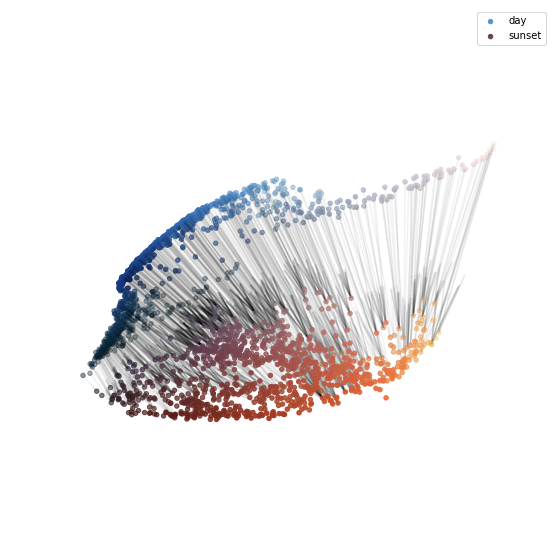

In [34]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_i[:, 0], x_i[:, 1], x_i[:, 2], c = x_i, label = 'day')
ax.scatter(x_f[:, 0], x_f[:, 1], x_f[:, 2], c = x_f, label = 'sunset')

x_f_closest = x_f[G.argmax(axis = 1)]
G_max = G.max(axis = 1)

ax.quiver(x_i[:, 0], x_i[:, 1], x_i[:, 2], 
          x_f_closest[:, 0] - x_i[:, 0], 
          x_f_closest[:, 1] - x_i[:, 1], 
          x_f_closest[:, 2] - x_i[:, 2], alpha = 0.05, color = 'k')

ax.legend()

ax.axis('off')

plt.savefig("results/pixel_matching.png")

### Performance measurements
---

We will now sample different number of points from the image and measure the elapsed time. 

Four approaches are compared:
- Our implementation of Sinkhorn
- The implementation of Sinkhorn from POT package
- The sparsified implementation
- The multigrid implementation

In [42]:
import ot

In [50]:
n_samples = 2 ** np.arange(5, 12)

t1, t1_err = [], []
t2, t2_err = [], []
t3, t3_err = [], []
t4, t4_err = [], []

for n in n_samples:
    x_i = I1.reshape(-1, 3)[np.random.randint(0, I1.shape[0] * I1.shape[1], n)]
    x_f = I2.reshape(-1, 3)[np.random.randint(0, I2.shape[0] * I2.shape[1], n)]

    C = cdist(x_i, x_f)

    a = np.ones(n) / n
    b = np.ones(n) / n
    
    n_sqrt = 2 * int(np.sqrt(n)) 
    if n > 100:
        n_sqrt *= 2
    
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-3, a = a, b = b)
    t1.append(t.average)
    t1_err.append(t.stdev)
    
    t = %timeit -o ot.bregman.sinkhorn_knopp(a = a, b = b, M = C, reg = 1e-3)
    t2.append(t.average)
    t2_err.append(t.stdev)
    
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-3, a = a, b = b, make_sparse = True, sparsification_strategy="keep_n_largest", min_nnz = n_sqrt)
    t3.append(t.average)
    t3_err.append(t.stdev)
    
    t = %timeit -o multigrid.sinkhorn_multigrid(C, x_i, x_f, reg_coarse= 1e-3, reg_fine= 1e-2, a = a, b = b, n_clusters_a = n_sqrt, n_clusters_b = n_sqrt)
    t4.append(t.average)
    t4_err.append(t.stdev)

21.5 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.2 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.7 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.3 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.1 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.2 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.8 ms ± 89.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.1 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
138 ms ± 4.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
166 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
66.2 ms ± 334 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.2 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
227 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
328 ms ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
137 ms ± 16.7 ms per 

/home/blackadder/NLA/optimal_transport_problem/src/sinkhorn.py:172: RuntimeWarning: overflow encountered in true_divide
  u = a / (K @ v)


190 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
92.3 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.74 s ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.95 s ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/blackadder/NLA/optimal_transport_problem/src/sinkhorn.py:172: RuntimeWarning: overflow encountered in true_divide
  u = a / (K @ v)


402 ms ± 6.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
337 ms ± 6.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.08 s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.5 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/blackadder/NLA/optimal_transport_problem/src/sinkhorn.py:172: RuntimeWarning: overflow encountered in true_divide
  u = a / (K @ v)


953 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
525 ms ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
plt.rc('font', family = 'serif')

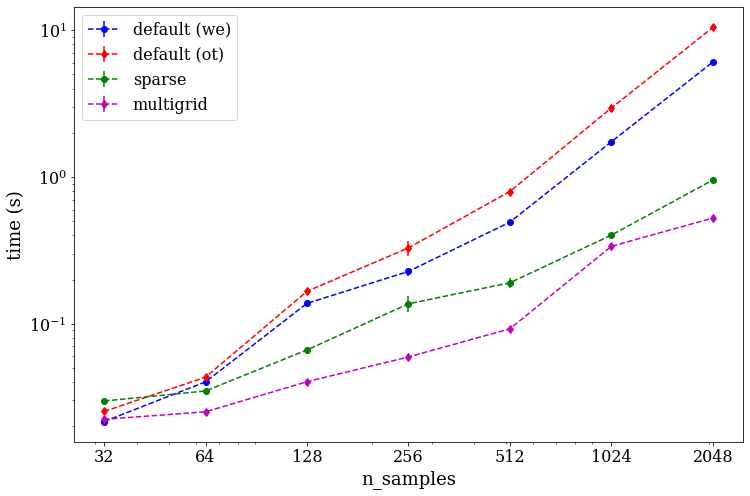

In [55]:
plt.figure(figsize=(12, 8))

plt.errorbar(n_samples, t1, t1_err, fmt = 'bo--', label = 'default (we)')
plt.errorbar(n_samples, t2, t2_err, fmt = 'rd--', label = 'default (ot)')
plt.errorbar(n_samples, t3, t3_err, fmt = 'go--', label = 'sparse')
plt.errorbar(n_samples, t4, t4_err, fmt = 'md--', label = 'multigrid')

plt.xscale('log')
plt.yscale('log')

plt.xticks(n_samples, size = 16)
plt.yticks(size = 16)
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlabel("n_samples", fontsize = 18)
plt.ylabel("time (s)", fontsize = 18)

plt.legend(fontsize = 16)

plt.savefig("timing_plots/image_transfer_time.png")

All in all we see that our implementation has a slight performance gain, comparing with the `Python OT` package, and 
the sparse and multigrid approaches results even in more noticeable performance gain. However, the sparsification rate needs to be
carefully adjusted in order to avoid numerical errors. All in all, keeping ~$\sqrt{n}$ elements seems a reasonable choice. 